In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

from data_processing import *
import data_processing as dp
import metrics


%load_ext autoreload
%autoreload 2

In [2]:
DATADIR = Path('data')

In [3]:
print(os.listdir(DATADIR))

['df_location_ratio.csv', '.DS_Store', 'df_phq9.csv', 'df_phq2_v2.csv', 'df_baseline_phq9.csv', 'df_passive_phone_communication_features_brighten_v2.csv', 'df_passive_mobility_features.csv', 'df_demographics.csv']


# Preparing the Data for Training

## Reading the Data

In [ ]:
phq9 = pd.read_csv(DATADIR / 'df_phq9.csv')
phq9.head()

In [ ]:
demographics = pd.read_csv(DATADIR / 'df_demographics.csv')
demographics.head()

In [ ]:
locations = pd.read_csv(DATADIR / 'df_location_ratio.csv')
locations.head()

## Cleaning a bit More

In [ ]:
phq9.rename(columns={'phq9Date': 'date'}, inplace=True)

In [ ]:
phq9.head()

## Joining the Tables

In [ ]:
from data_processing import *
import data_processing as dp
import metrics

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Check balanced accuracy instead of raw and plot distributions
# Maybe look at the distr of the RMSE for regression

# Also, maybe use the std. instead of just the mean for features
# Try to use significant cross-validation
# Maybe apply feature selection:
#    * Automatic feature selection
#    * Manual: e.g. greatly reduce the number of location categories except for work and home
# Try to see the effect of some hyperparameters of the random forest

# Use only a few initial weeks in training for some patients
# Maybe try to improve the context with previous information

# Try different targets:
#    * The original sum_phq9 (not the column sum of 9 questions)
#    * Target each question separately

def train(TYPE='classification', TARGET='value', SPLIT_BY_PARTICIPANT=False, TEST_TAKE_FIRST=0, SEED=550, return_csv=False):

    phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET)
    locations = load_locations(DATADIR / 'df_location_ratio.csv')
    demographics = load_demographics(DATADIR / 'df_demographics.csv')
    mobility = load_passive_mobility(DATADIR / 'df_passive_mobility_features.csv')
    phone = load_passive_phone(DATADIR / 'df_passive_phone_communication_features_brighten_v2.csv')

    combined, merge_result = dp.combine(
        phq9, 
        dailies=[
            ('locations', locations), 
            # ('mobility', mobility),
            # ('phone', phone)
        ], 
        constants=[
            demographics
        ],
        prev_phq9=False
    )
    combined = dp.rf_preprocess(combined)

    if return_csv:
        return combined
    
    if SPLIT_BY_PARTICIPANT:
        x_train, x_test, y_train, y_test = dp.train_test_split_participant(combined, 0.15, random_state=SEED,
                                                                           test_take_first=TEST_TAKE_FIRST)
    else:
        x, y = dp.xy_split(combined)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=SEED, stratify=y)

    print('Train set shape:', x_train.shape)
    print('Test set shape:', x_test.shape)
    n = len(y_train) + len(y_test)
    train_pct = len(y_train) / n * 100
    test_pct = len(y_test) / n * 100
    print(f'Ratio: {train_pct:.2f}%/{test_pct:.2f}%')
    print()


    if TYPE == 'regression':
        def rmse(x, y):
            return np.sqrt(((x - y)**2).mean())

        model = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)

        train_rmse = rmse(y_train, model.predict(x_train))
        test_rmse = rmse(y_test, model.predict(x_test))
        print(f'Train set RMSE: {train_rmse:.4f}')
        print(f'Test set RMSE:  {test_rmse:.4f}')

        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        print(f'Train score:', train_score)
        print(f'Test score:', test_score)
        
        return train_score, test_score
    elif TYPE == 'classification':

        model = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)

        y_full = np.concatenate((y_train, y_test))
        random_acc = 100 * (y_full == np.random.randint(0, 5, size=y_full.shape)).mean()
        # train_acc = 100 * model.score(x_train, y_train)
        # test_acc = 100 * model.score(x_test, y_test)
        # print(f'Train set accuracy: {train_acc:.2f}%') 
        # print(f'Test set accuracy:  {test_acc:.2f}%')
        print(f'Random full accuracy: {random_acc:.2f}%')

        figs, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        print('Train set:')
        train_bal, train_mean = metrics.accuracy_info(y_train, model.predict(x_train), prefix='Training', ax=axes[0])

        print('Test set:')
        test_bal, test_mean = metrics.accuracy_info(y_test, model.predict(x_test), prefix='Test', ax=axes[1])
        
        return train_bal, test_bal

In [ ]:
def train_RandomForest(combined, type = 'regression'):
    SEED = 433
    x, y = dp.xy_split(combined)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=SEED)

    print('Train set shape:', x_train.shape)
    print('Test set shape:', x_test.shape)
    print()

    if type == 'regression':
        def rmse(x, y):
            return np.sqrt(((x - y)**2).mean())

        model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)
        
        train_rmse = rmse(y_train, model.predict(x_train))
        test_rmse = rmse(y_test, model.predict(x_test))
        print(f'Train set RMSE: {train_rmse:.4f}')
        print(f'Test set RMSE:  {test_rmse:.4f}')
        
        # print(f'Train score:', model.score(x_train, y_train),f'balanced accuracy score: {balanced_accuracy_score(y_train, model.predict(x_train)):.2f}') 
        # print(f'Test score:', model.score(x_test, y_test), f'balanced accuracy score: {balanced_accuracy_score(y_test, model.predict(x_test)):.2f}') 
        print(f'Train score:', model.score(x_train, y_train)) 
        print(f'Test score:', model.score(x_test, y_test)) 

    elif type == 'classification':
        model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)
        
        train_acc = 100 * model.score(x_train, y_train)
        test_acc = 100 * model.score(x_test, y_test)
        print(f'Train set accuracy: {train_acc:.2f}%', f'balanced accuracy score: {balanced_accuracy_score(y_train, model.predict(x_train)):.2f}') 
        print(f'Test set accuracy:  {test_acc:.2f}%', f'balanced accuracy score: {balanced_accuracy_score(y_test, model.predict(x_test)):.2f}') 
        
    # return 1,2
    return [model.score(x_train, y_train), model.score(x_test, y_test)]

## change the targets

In [4]:
locations = dp.load_locations(DATADIR / 'df_location_ratio.csv')
demographics = dp.load_demographics(DATADIR / 'df_demographics.csv')
baseline_phq9 = dp.load_baselinephq9(DATADIR / 'df_baseline_phq9.csv')

### 1. target = sum_phq9 or phq9_sum
for v2, the sum_phq is equal to phq9_sum

In [ ]:
TYPE = 'regression' # regression|classification
TARGET = 'value' # diff|value
SEED = 433

target_list = ['sum_phq9', 'phq9_sum']
target_sum_phq9 = [True, False]
phq9_index = 0
train_scores = []
test_scores = []

for target_name, sum_phq9_flag in zip(target_list, target_sum_phq9):
    print('target:', target_name)
    phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET, sum_phq9 = sum_phq9_flag, phq9_index= phq9_index)
    combined = dp.combine(phq9, dailies=[('locations', locations)], constants=[demographics])
    combined = dp.rf_preprocess(combined)
    train_score, test_score = train_RandomForest(combined)
    train_scores.append(train_score)
    test_scores.append(test_score)

### 2. target = each phq9 questions
1. the result is worse than the sum
2. phq9_3,5 ,6, 9 are better than other, test score around 40%

In [ ]:
TYPE = 'regression' # regression|classification
TARGET = 'value' # diff|value
SEED = 433

target_list = ['phq9_1', 'phq9_2', 'phq9_3', 'phq9_4', 'phq9_5', 'phq9_6', 'phq9_7', 'phq9_8', 'phq9_9']
sum_phq9 = True
phq9_index_list = [1,2,3,4,5,6,7,8,9]
train_scores = []
test_scores = []

for target_name, phq9_index in zip(target_list, phq9_index_list):
    print('target:', target_name)
    phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET, sum_phq9 = sum_phq9, phq9_index= phq9_index)
    combined = dp.combine(phq9, dailies=[('locations', locations)], constants=[demographics])
    combined = dp.rf_preprocess(combined)
    train_RandomForest(combined)
    train_score, test_score = train_RandomForest(combined)
    train_scores.append(train_score)
    test_scores.append(test_score)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax= plt.subplots(1,2,figsize=(18, 8))

# ax[0].set_title('Insert Title Here')

ax[0].bar(target_list, train_scores)
ax[0].set_title('train R2')
ax[1].bar(target_list, test_scores)
ax[1].set_title('test R2')


### 3.target = phq2 (sum or each question)
we got more training samples than phq9, but the X is more sparse than phq9.

In [ ]:
phq2

In [ ]:
TYPE = 'regression' # regression|classification
TARGET = 'value' # diff|value
SEED = 433

target_list = ['phq2_1', 'phq2_2', 'phq2_sum']

phq2_index_list = [1,2,0]
train_scores = []
test_scores = []


for target_name, phq2_index in zip(target_list, phq2_index_list):
    print('target:', target_name)
    phq2 = dp.load_phq2_targets(DATADIR / 'df_phq2_v2.csv', type=TYPE, target='value', phq2_index= phq2_index)
    combined = dp.combine(phq2, dailies=[('locations', locations)], constants=[demographics])
    combined = dp.rf_preprocess(combined)
    train_score, test_score = train_RandomForest(combined)
    train_scores.append(train_score)
    test_scores.append(test_score)

In [ ]:
fig, ax= plt.subplots(1,2,figsize=(18, 8))

# ax[0].set_title('Insert Title Here')

ax[0].bar(target_list, train_scores)
ax[0].set_title('train R2')
ax[1].bar(target_list, test_scores)
ax[1].set_title('test R2')

In [ ]:
phq9.participant_id.unique().size
# combined.participant_id.unique().size
# locations.participant_id.unique().size
locations

## RandomForest tuning

In [ ]:
#training set 
df_training = combined.drop(combined.columns.intersection(['target', 'participant_id', 'date']), axis=1)

In [ ]:

model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=SEED)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 400, stop = 800, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
max_samples =  [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
criterion = ['squared_error', 'absolute_error', 'poisson','MAE']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples':max_samples
            #    'bootstrap': bootstrap
               }
pprint(random_grid)

In [ ]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type='regression', target='value', sum_phq9 = True, phq9_index= 0)
combined = dp.combine(phq9, dailies=[('locations', locations)], constants=[demographics])
combined = dp.rf_preprocess(combined)

In [ ]:
SEED = 433
x, y = dp.xy_split(combined)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=SEED)
print('Train set shape:', x_train.shape)
print('Test set shape:', x_test.shape)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=SEED, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
model = RandomForestRegressor(n_estimators= 700,
 min_samples_split= 2,
 min_samples_leaf= 1,
 max_features = 'log2',
 max_samples = 0.9,
 max_depth =20)
 
model.fit(x_train, y_train)
print(f'Train score:', model.score(x_train, y_train)) 
print(f'Test score:', model.score(x_test, y_test)) 

# print('feature sorted by importances')
# df_training.columns[(model.feature_importances_).argsort()[::-1][:20]]

## Aggregating all the values until the current PHQ9

In [5]:
from data_processing import *
import data_processing as dp
import metrics

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Check balanced accuracy instead of raw and plot distributions
# Maybe look at the distr of the RMSE for regression

# Also, maybe use the std. instead of just the mean for features
# Try to use significant cross-validation
# Maybe apply feature selection:
#    * Automatic feature selection
#    * Manual: e.g. greatly reduce the number of location categories except for work and home
# Try to see the effect of some hyperparameters of the random forest

# Use only a few initial weeks in training for some patients
# Maybe try to improve the context with previous information

# Try different targets:
#    * The original sum_phq9 (not the column sum of 9 questions)
#    * Target each question separately


def train(
    TYPE="classification",
    TARGET="value",
    SPLIT_BY_PARTICIPANT=False,
    TEST_TAKE_FIRST=0,
    PREVIOUS_NUM=0,
    ALL_PREVIOUS_DATA=False,
    WEIGHTED=False,
    WEIGHTED_DAYS=True,
    EWM_HALFLIFE = '7 days',
    EWM_SPAN = 5,
    SEED=550,
    return_csv=False,
    daily_reduction = ['mean'],
):

    phq9 = dp.load_phq9_targets(DATADIR / "df_phq9.csv", type=TYPE, target=TARGET)
    locations = load_locations(DATADIR / "df_location_ratio.csv")
    demographics = load_demographics(DATADIR / "df_demographics.csv")
    mobility = load_passive_mobility(DATADIR / "df_passive_mobility_features.csv")
    phone = load_passive_phone(
        DATADIR / "df_passive_phone_communication_features_brighten_v2.csv"
    )

    # combine_additively
    combined, merged = dp.combined_additively(
        phq9,
        dailies=[
            ("locations", locations),
            ('mobility', mobility),
        #     # ('phone', phone)
        ],
        constants=[demographics],
        prev_phq9=False,
        all_previous_data=ALL_PREVIOUS_DATA,
        previous_num=PREVIOUS_NUM,
        weighted=WEIGHTED,
        weighted_days=WEIGHTED_DAYS,
        ewm_halflife=EWM_HALFLIFE,
        ewm_span=EWM_SPAN,  # Specify decay in terms of span
        daily_reduction=daily_reduction
    )
    
    combined = dp.rf_preprocess(combined)

    if return_csv:
        return combined

    if SPLIT_BY_PARTICIPANT:
        x_train, x_test, y_train, y_test = dp.train_test_split_participant(
            combined, 0.15, random_state=SEED, test_take_first=TEST_TAKE_FIRST
        )
    else:
        x, y = dp.xy_split(combined)
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=0.15, random_state=SEED, stratify=y
        )

    print("Train set shape:", x_train.shape)
    print("Test set shape:", x_test.shape)
    n = len(y_train) + len(y_test)
    train_pct = len(y_train) / n * 100
    test_pct = len(y_test) / n * 100
    print(f"Ratio: {train_pct:.2f}%/{test_pct:.2f}%")
    print()

    if TYPE == "regression":

        def rmse(x, y):
            return np.sqrt(((x - y) ** 2).mean())

        model = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)

        train_rmse = rmse(y_train, model.predict(x_train))
        test_rmse = rmse(y_test, model.predict(x_test))
        print(f"Train set RMSE: {train_rmse:.4f}")
        print(f"Test set RMSE:  {test_rmse:.4f}")

        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        print(f"Train score:", train_score)
        print(f"Test score:", test_score)

        return train_score, test_score
    elif TYPE == "classification":

        model = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)

        y_full = np.concatenate((y_train, y_test))
        random_acc = 100 * (y_full == np.random.randint(0, 5, size=y_full.shape)).mean()
        # train_acc = 100 * model.score(x_train, y_train)
        # test_acc = 100 * model.score(x_test, y_test)
        # print(f'Train set accuracy: {train_acc:.2f}%')
        # print(f'Test set accuracy:  {test_acc:.2f}%')
        print(f"Random full accuracy: {random_acc:.2f}%")

        figs, axes = plt.subplots(1, 2, figsize=(16, 6))

        print("Train set:")
        train_bal, train_mean = metrics.accuracy_info(
            y_train, model.predict(x_train), prefix="Training", ax=axes[0]
        )

        print("Test set:")
        test_bal, test_mean = metrics.accuracy_info(
            y_test, model.predict(x_test), prefix="Test", ax=axes[1]
        )

        return train_bal, test_bal


In [70]:
combined, merged = dp.combined_additively(
        phq9,
        dailies=[
            ("locations", locations),
            ('mobility', mobility),
        #     # ('phone', phone)
        ],
        constants=[demographics],
        weighted=True,
        ewm_halflife='7 days',
    )

7 days ddddd


Daily reduction method: mean
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.629%
Test set:
Mean accuracy: 30.159%
Balanced accuracy: 25.381%
Daily reduction method: max
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.630%
Test set:
Mean accuracy: 30.688%
Balanced accuracy: 25.397%
Daily reduction method: min
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.687%
Test set:
Mean accuracy: 28.042%
Balanced accuracy: 24.404%
Daily reduction method: std
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.081%
Balanced accuracy: 94.425%
Test set:
Mean accuracy: 29.630%
Balanced accur

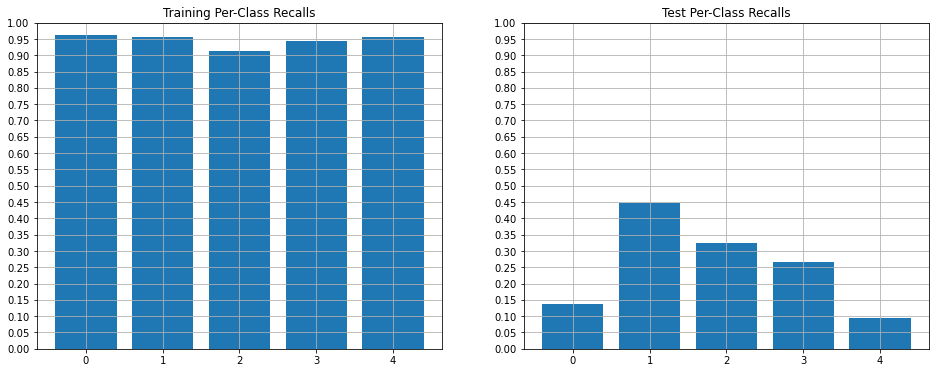

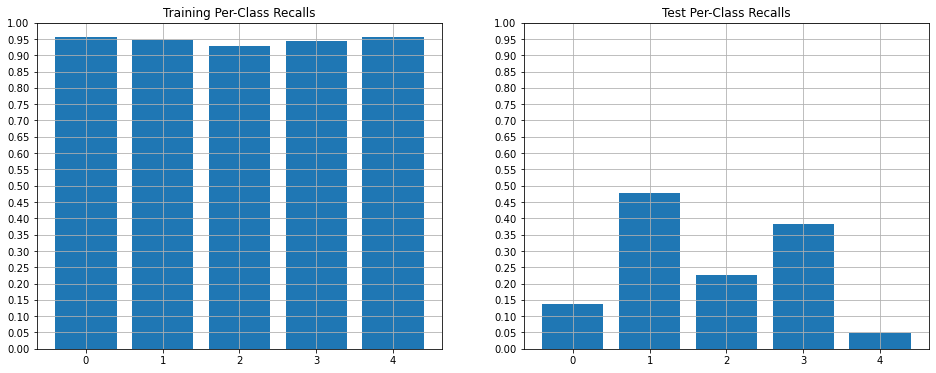

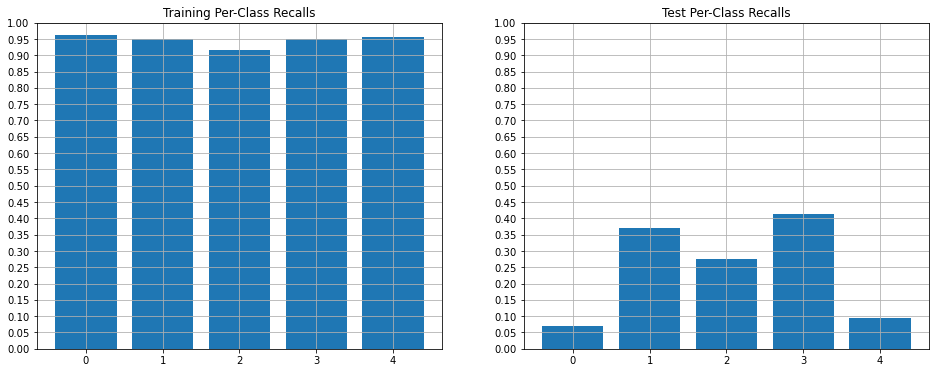

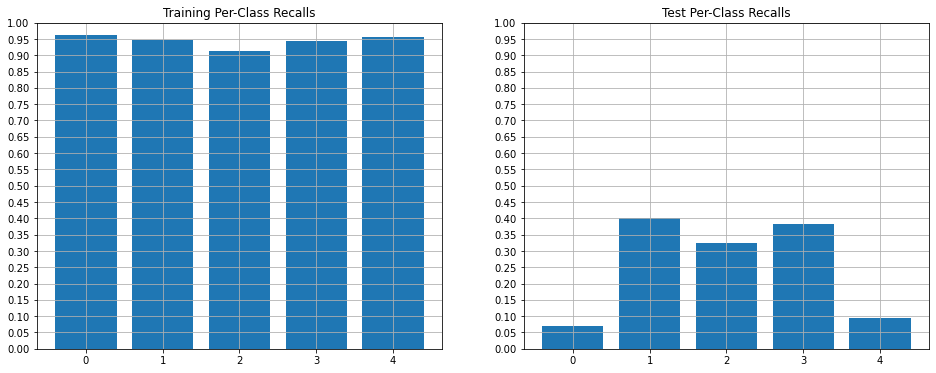

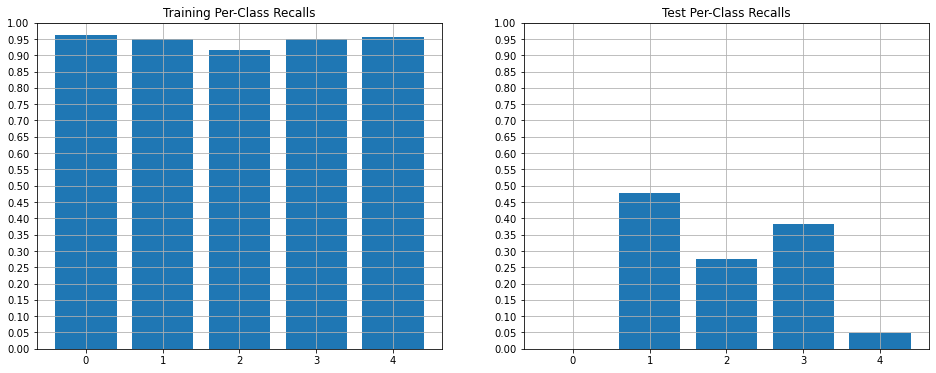

In [58]:
reduct_method = ['mean', 'max', 'min', 'std','median']
train_results = []
test_results = []

for method in reduct_method:
    print(f"Daily reduction method: {method}")
    train_bal, test_bal = train(SPLIT_BY_PARTICIPANT=True,TEST_TAKE_FIRST=0, daily_reduction=[method] )
    train_results.append(train_bal)
    test_results.append(test_bal)

Text(0.5, 1.0, 'reduction method - split by participant - do not take previous test')

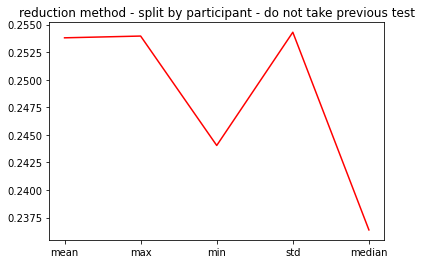

In [59]:
# plt.plot(reduct_method, train_results, 'b', label='Train')
plt.plot(reduct_method, test_results, 'r', label='test')
plt.title('reduction method - split by participant - do not take previous test') #not split by participant, do not take any previous role

Daily reduction method: ['mean']
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.629%
Test set:
Mean accuracy: 30.159%
Balanced accuracy: 25.381%
Daily reduction method: ['mean', 'max']
Train set shape: (963, 89)
Test set shape: (189, 89)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.629%
Test set:
Mean accuracy: 31.746%
Balanced accuracy: 24.627%
Daily reduction method: ['mean', 'max', 'std']
Train set shape: (963, 122)
Test set shape: (189, 122)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.687%
Test set:
Mean accuracy: 31.217%
Balanced accuracy: 24.691%
Daily reduction method: ['mean', 'std']
Train set shape: (963, 89)
Test set shape: (189, 89)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.645

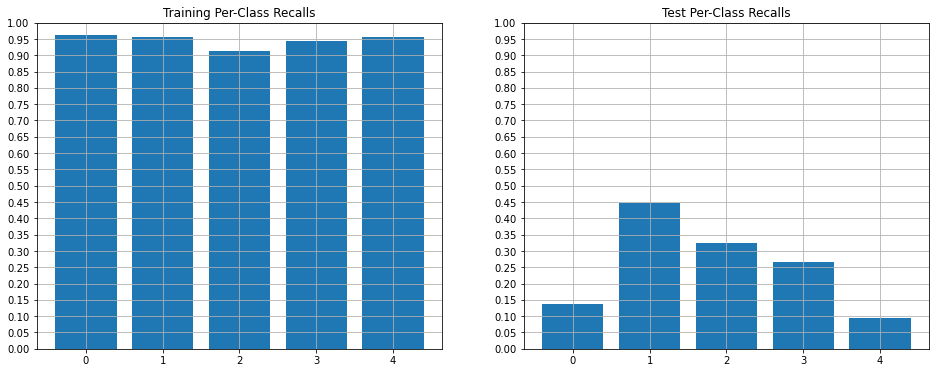

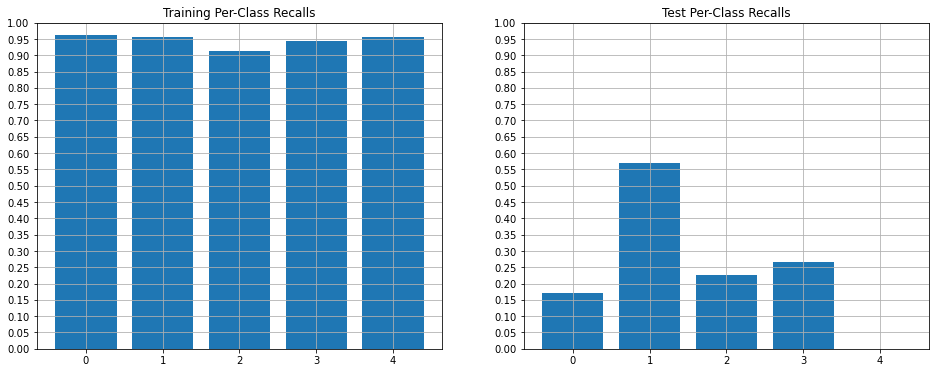

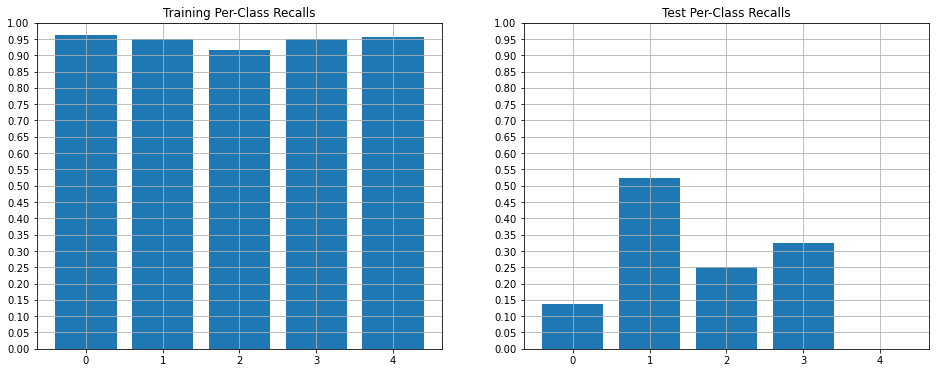

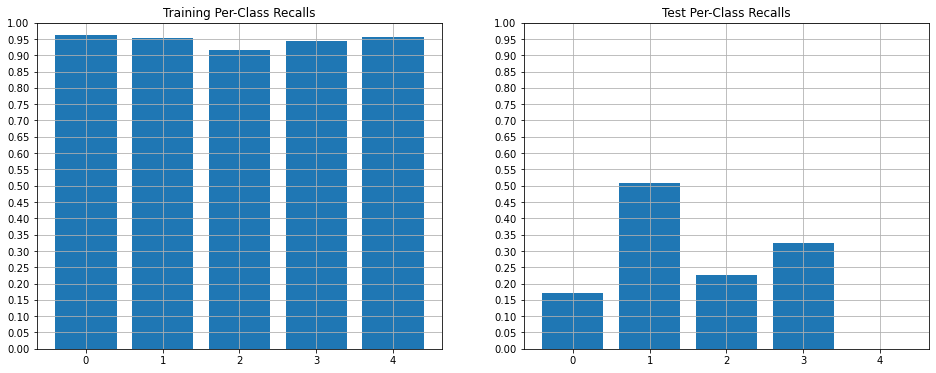

In [63]:
reduct_method = [['mean'], ['mean','max'], ['mean','max','std'],['mean','std']]
train_results = []
test_results = []

for method in reduct_method:
    print(f"Daily reduction method: {method}")
    train_bal, test_bal = train(SPLIT_BY_PARTICIPANT=True,TEST_TAKE_FIRST=0, daily_reduction=method )
    train_results.append(train_bal)
    test_results.append(test_bal)

Text(0.5, 1.0, 'reduction method - split by participant - do not take previous test')

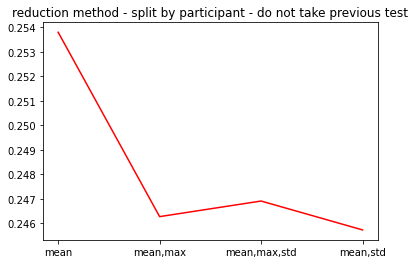

In [64]:
reduct_method = ['mean', 'mean,max', 'mean,max,std','mean,std']
plt.plot(reduct_method, test_results, 'r', label='test')
plt.title('reduction method - split by participant - do not take previous test') #not split by participant, do not take any previous role

In [104]:
previous_num_list = np.arange(0,11,1).tolist()
previous_num_list.insert(0, 'base')


['base', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.629%
Test set:
Mean accuracy: 30.159%
Balanced accuracy: 25.381%


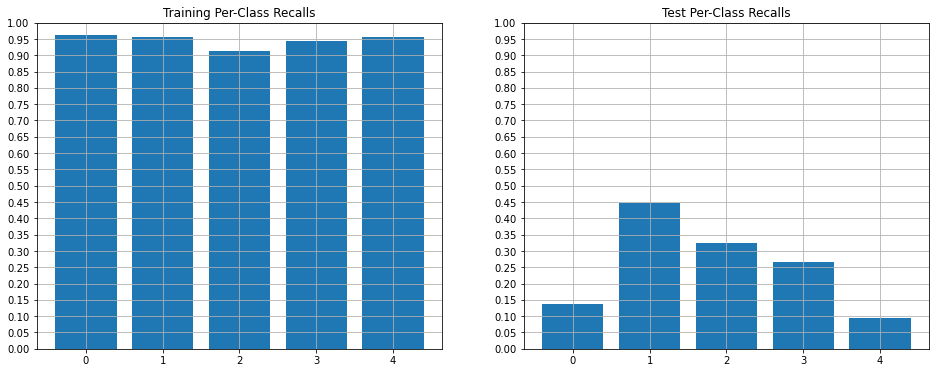

In [17]:
train_bal, test_bal = train(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=0, WEIGHTED=False, PREVIOUS_NUM=0)

Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 99.896%
Balanced accuracy: 99.870%
Test set:
Mean accuracy: 24.868%
Balanced accuracy: 19.282%


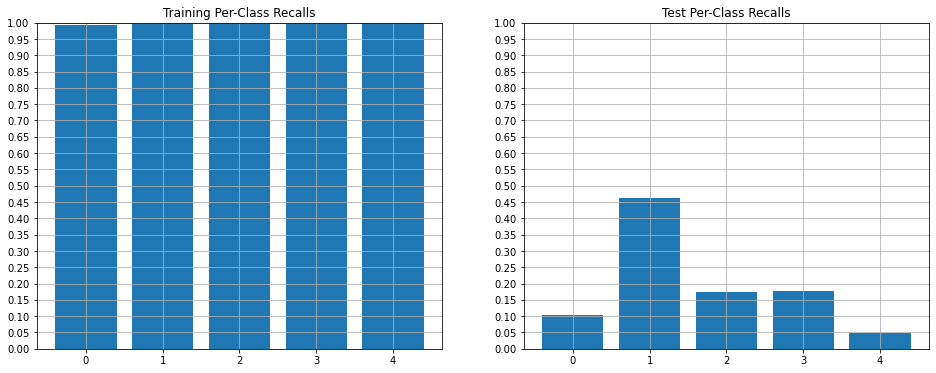

In [15]:
train_bal, test_bal = train(ALL_PREVIOUS_DATA = True, SPLIT_BY_PARTICIPANT=True, WEIGHTED = False)

Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.629%
Test set:
Mean accuracy: 30.159%
Balanced accuracy: 25.381%
previous_num: 0
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.629%
Test set:
Mean accuracy: 30.159%
Balanced accuracy: 25.381%
previous_num: 1
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.629%
Test set:
Mean accuracy: 30.159%
Balanced accuracy: 25.381%
previous_num: 2
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.808%
Balanced accuracy: 95.119%
Test set:
Mean accuracy: 29.101%
Balanced accuracy: 21.945%
previous_num: 3
Train set shape: (963, 56)
Test set 

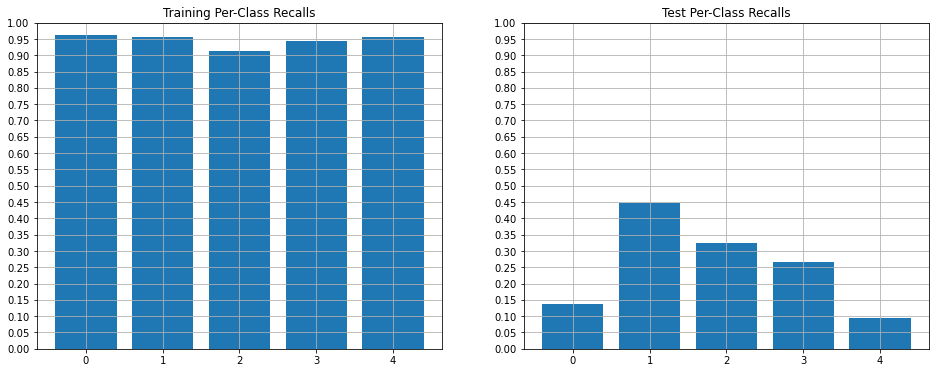

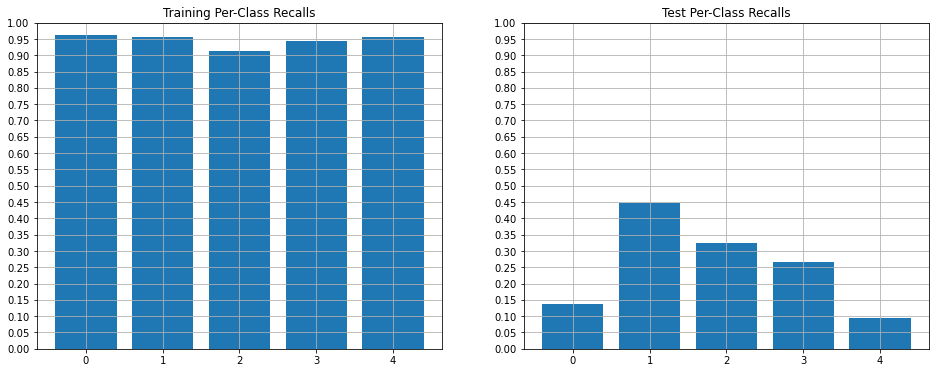

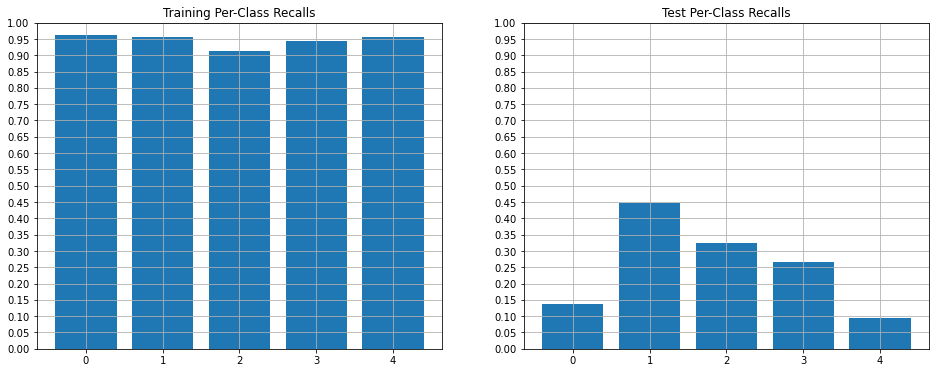

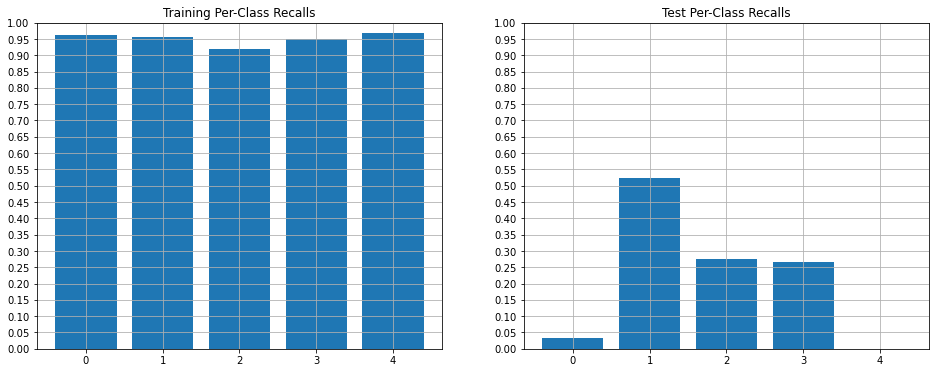

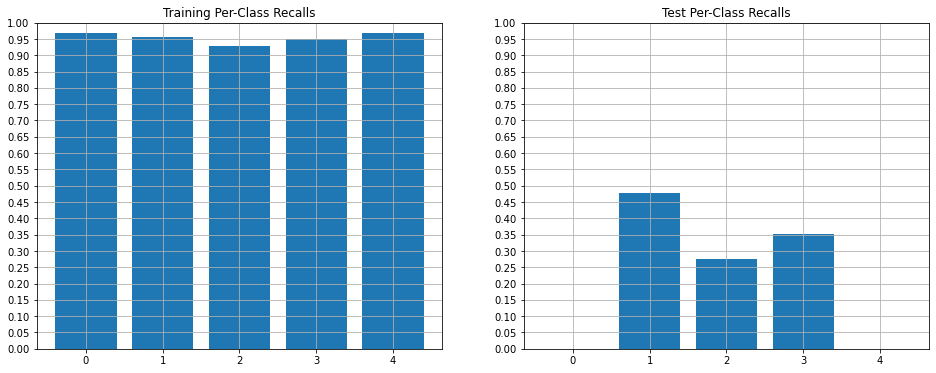

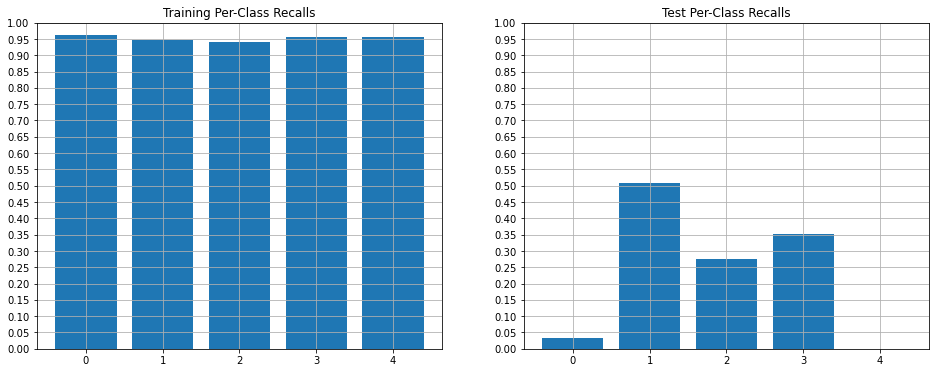

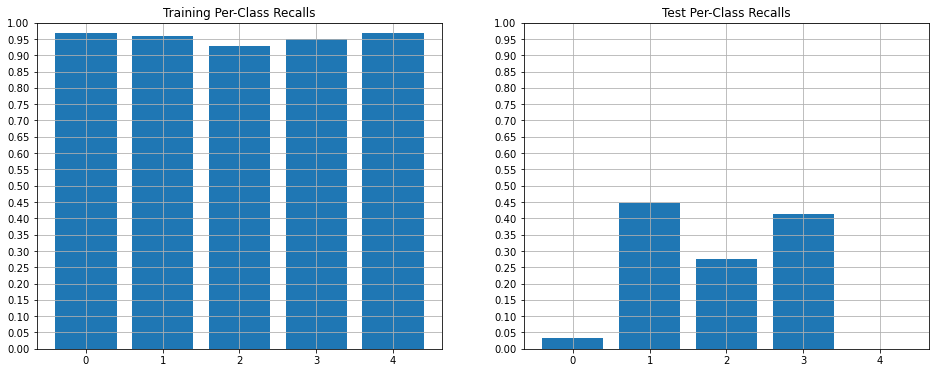

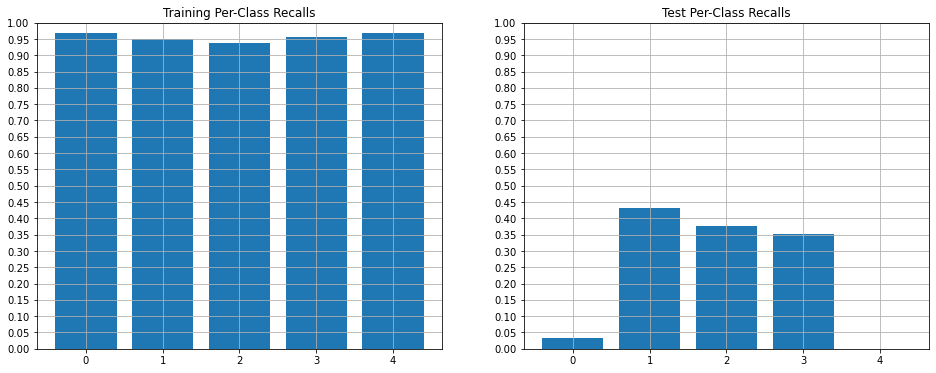

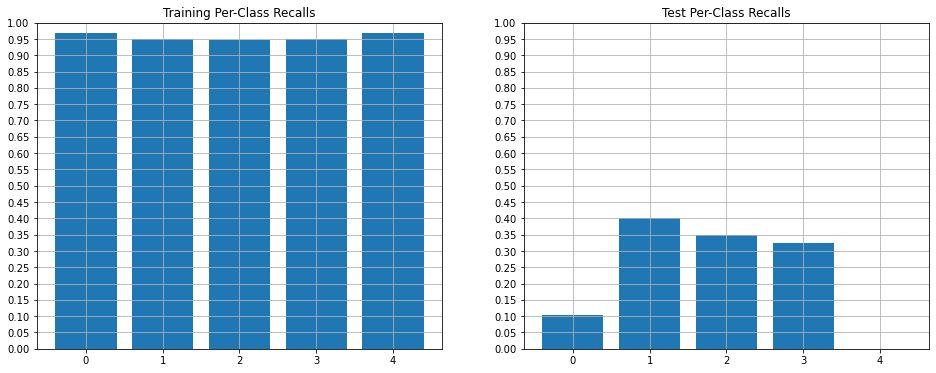

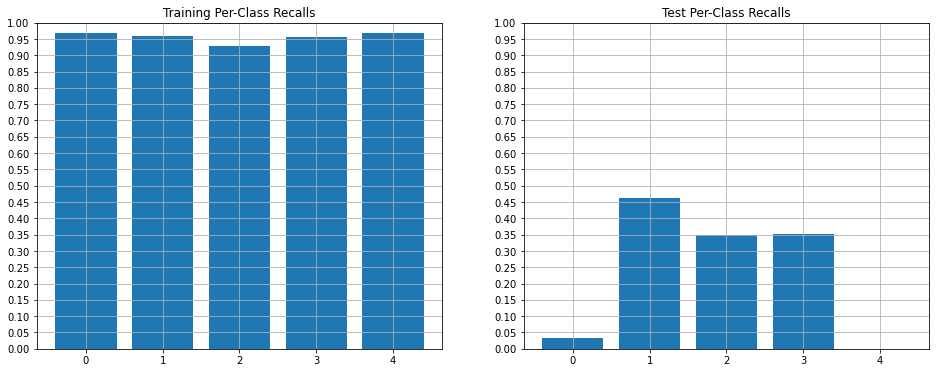

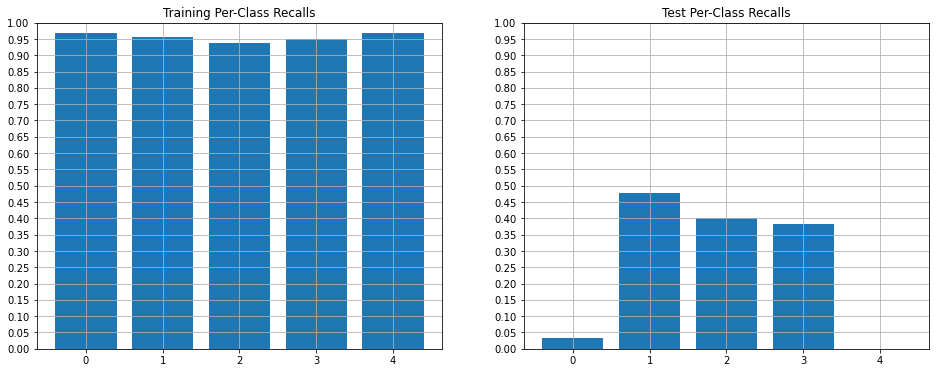

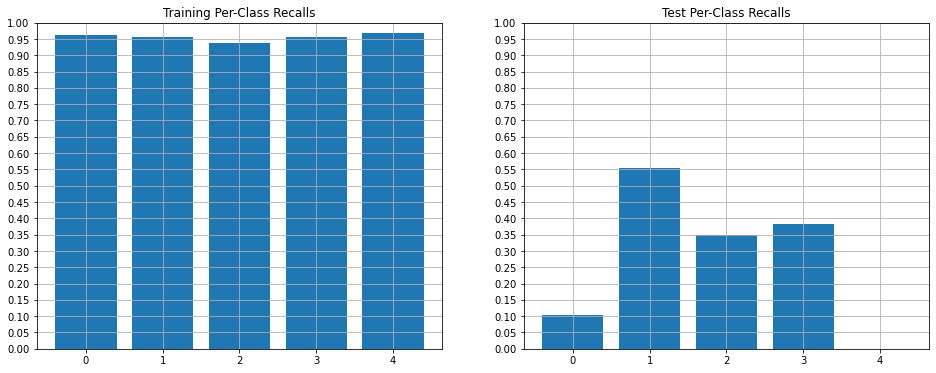

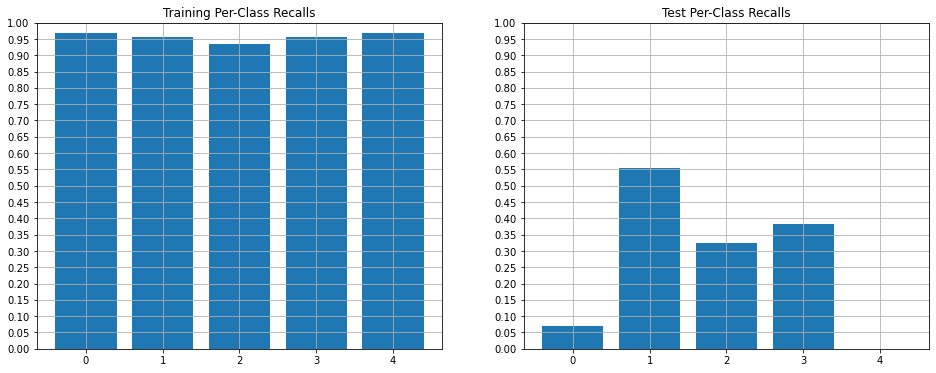

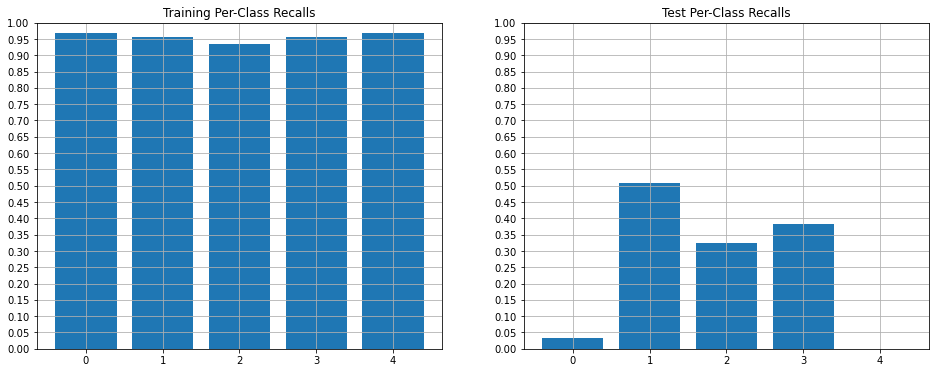

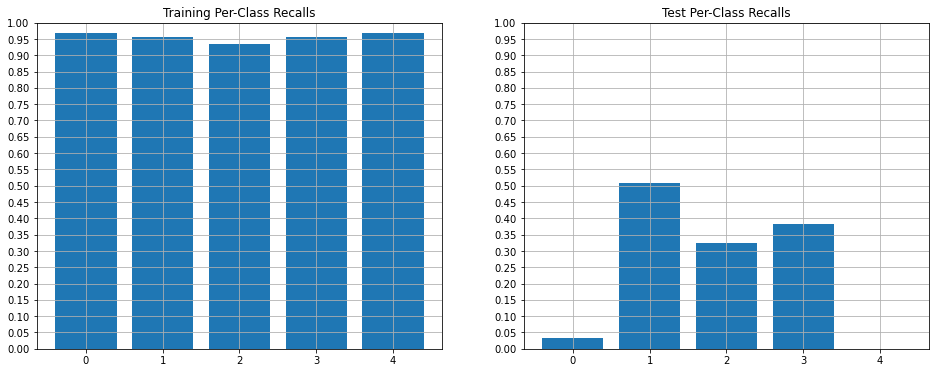

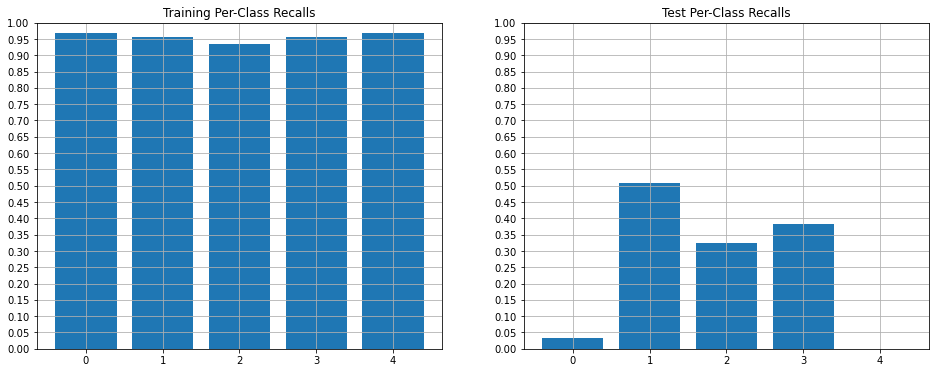

In [110]:
previous_num_list = np.arange(0,15,1).tolist()
previous_num_list.insert(0, 'base')
train_results = []
test_results = []

base_train_bal, base_test_bal = train(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=0, WEIGHTED=False, PREVIOUS_NUM=0)
train_results.append(base_train_bal)
test_results.append(base_test_bal)

for num in previous_num_list[1:]:
    print('previous_num:',num)
    train_bal, test_bal = train(PREVIOUS_NUM = num, ALL_PREVIOUS_DATA = False, SPLIT_BY_PARTICIPANT=True, WEIGHTED = False)
    train_results.append(train_bal)
    test_results.append(test_bal)
    

Text(0.5, 1.0, 'aggregate previous test information - split by participant - not weighted - mean')

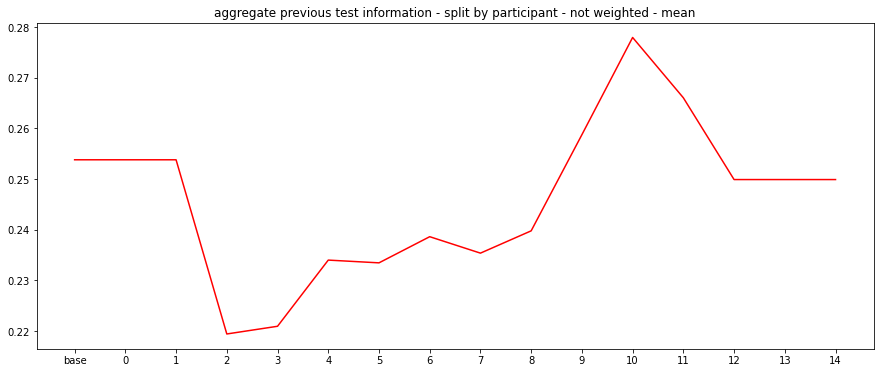

In [111]:
# plt.plot(halflife_list, train_results, 'b', label='Train')
plt.figure(figsize=(15, 6))
plt.plot(previous_num_list, test_results, 'r', label='test')
plt.title('aggregate previous test information - split by participant - not weighted - mean') #not split by participant, do not take any previous role

Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.629%
Test set:
Mean accuracy: 30.159%
Balanced accuracy: 25.381%
halflife length is: 1 days
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 95.223%
Balanced accuracy: 95.511%
Test set:
Mean accuracy: 33.862%
Balanced accuracy: 27.484%
halflife length is: 3 days
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 95.327%
Balanced accuracy: 95.641%
Test set:
Mean accuracy: 31.746%
Balanced accuracy: 25.666%
halflife length is: 7 days
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 95.327%
Balanced accuracy: 95.626%
Test set:
Mean accuracy: 32.275%
Balanced accuracy: 26.535%
halflife length is:

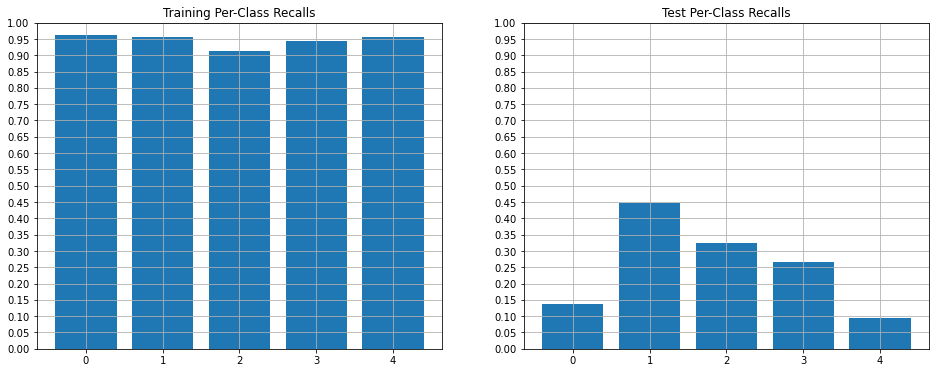

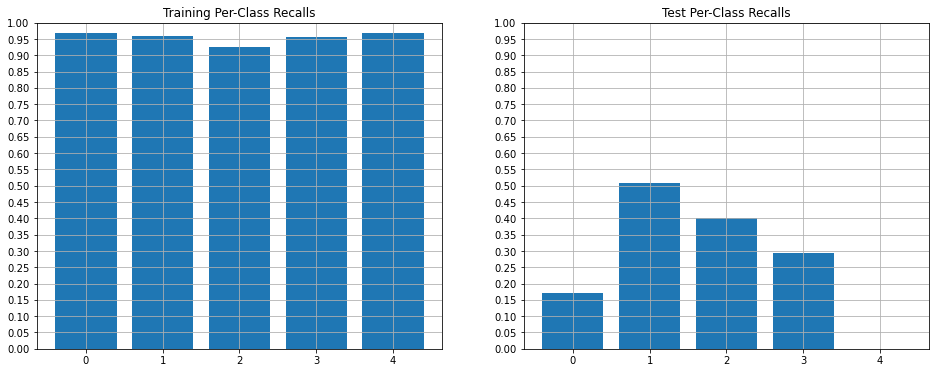

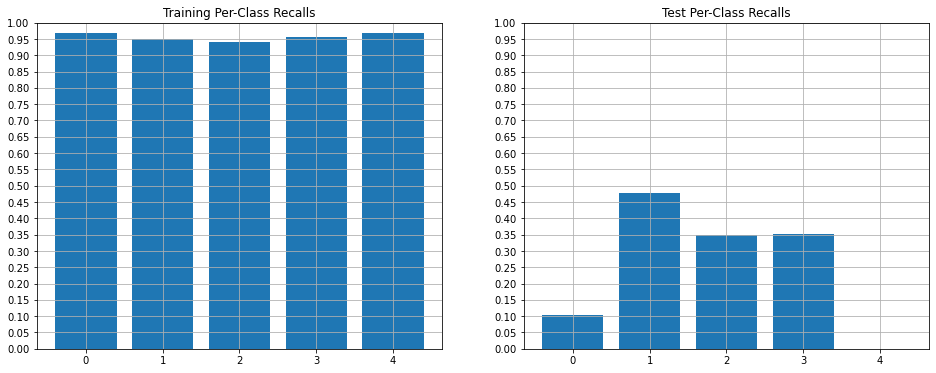

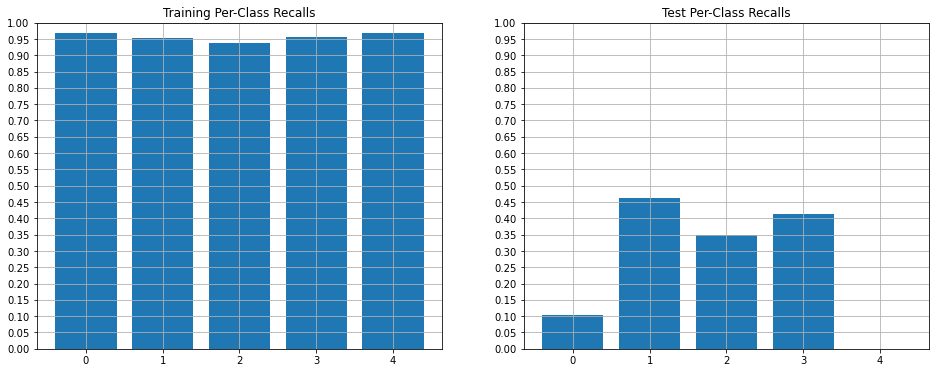

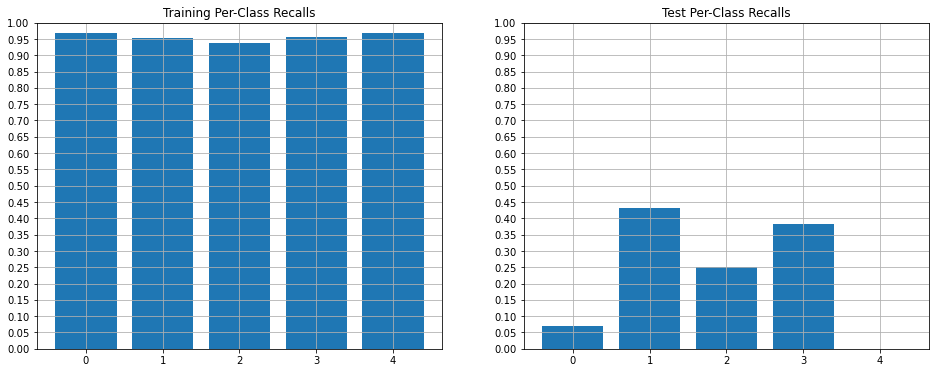

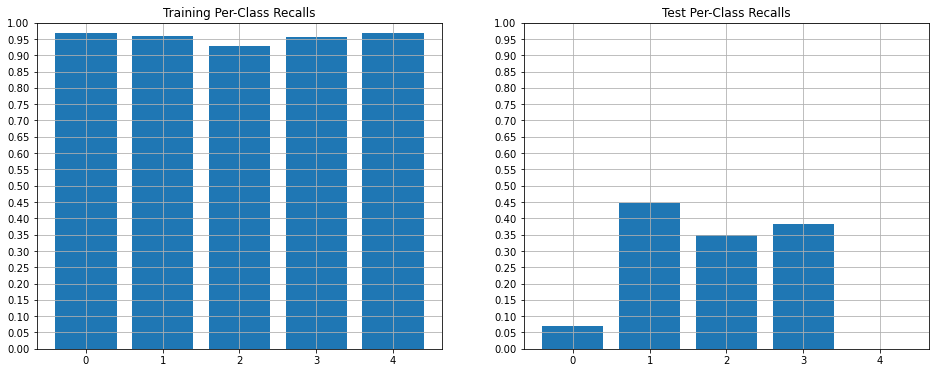

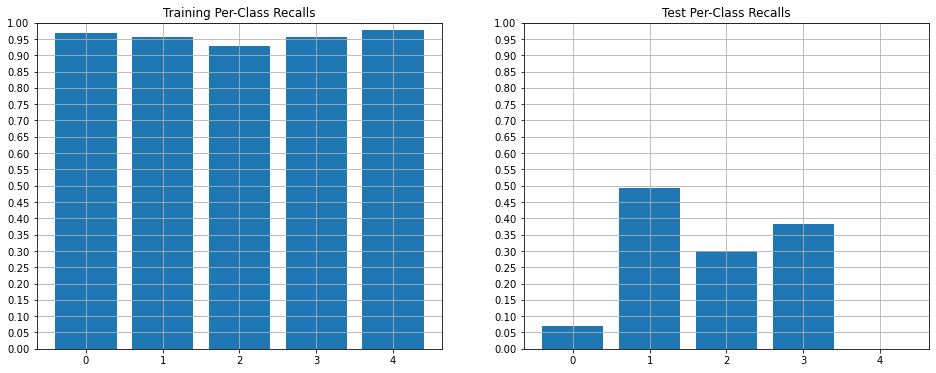

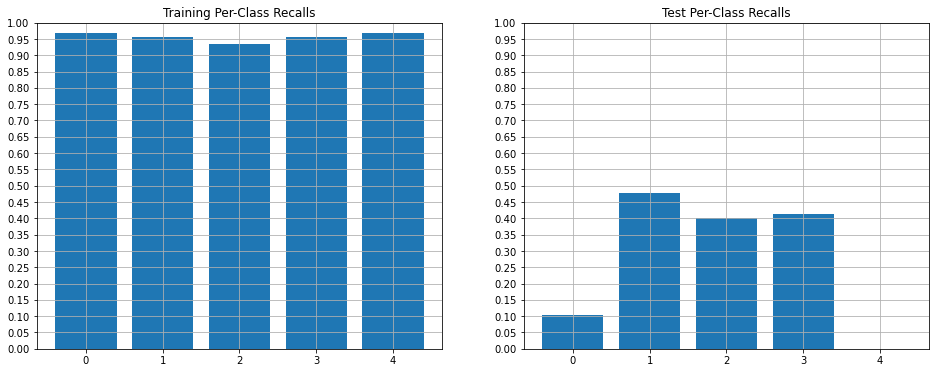

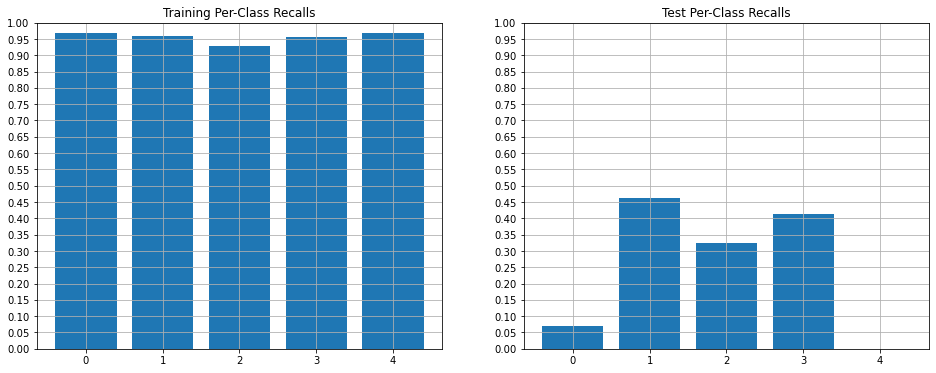

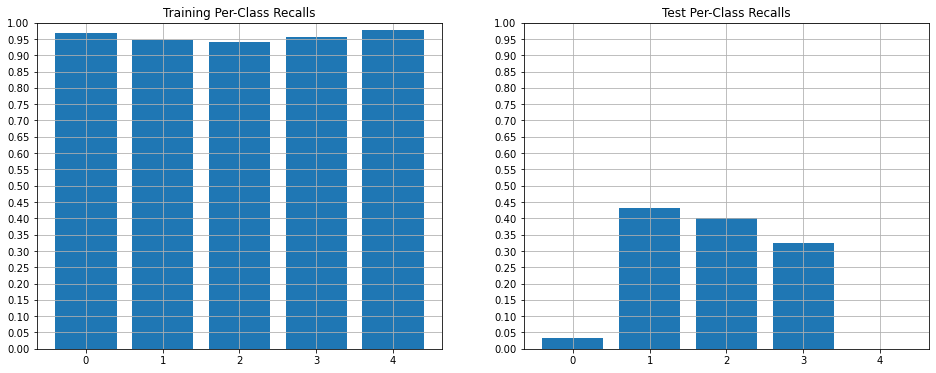

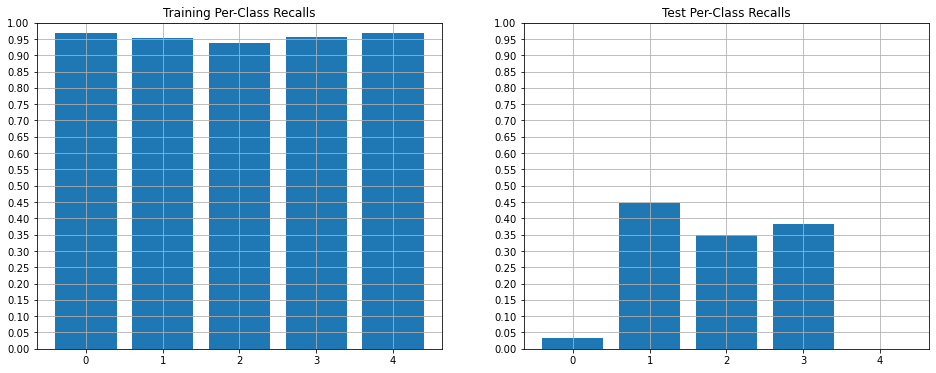

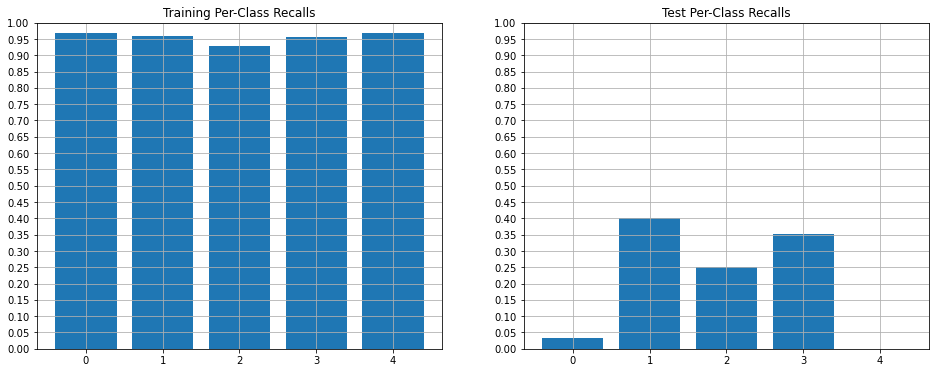

In [112]:
halflife_list = ['base', '1 days','3 days','7 days', '10 days','12 days','13 days','14 days','15 days','16 days','20 days', '30 days']
train_results = []
test_results = []

base_train_bal, base_test_bal = train(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=0, WEIGHTED=False, PREVIOUS_NUM=0)
train_results.append(base_train_bal)
test_results.append(base_test_bal)

for halflife in halflife_list[1:]:
    print(f"halflife length is: {halflife}")
    train_bal, test_bal = train(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=0, WEIGHTED=True, EWM_HALFLIFE=halflife)
    train_results.append(train_bal)
    test_results.append(test_bal)

Text(0.5, 1.0, 'length of halflife - split by participant - weighted ewm by date ')

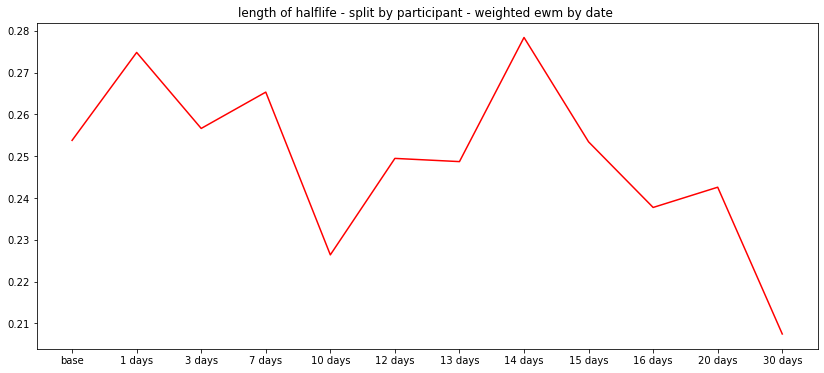

In [113]:
# plt.plot(halflife_list, train_results, 'b', label='Train')
plt.figure(figsize=(14, 6))
plt.plot(halflife_list, test_results, 'r', label='test')
plt.title('length of halflife - split by participant - weighted ewm by date ') #not split by participant, do not take any previous role

Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.629%
Test set:
Mean accuracy: 30.159%
Balanced accuracy: 25.381%
span length is: 1
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 94.393%
Balanced accuracy: 94.629%
Test set:
Mean accuracy: 30.159%
Balanced accuracy: 25.381%
span length is: 2
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 95.327%
Balanced accuracy: 95.610%
Test set:
Mean accuracy: 32.275%
Balanced accuracy: 25.400%
span length is: 3
Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 95.327%
Balanced accuracy: 95.594%
Test set:
Mean accuracy: 30.159%
Balanced accuracy: 24.169%
span length is: 4
Train set shape: (963, 56)
T

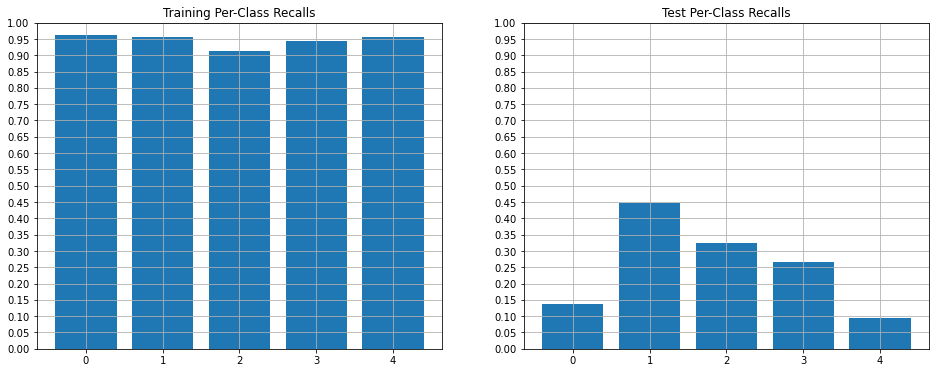

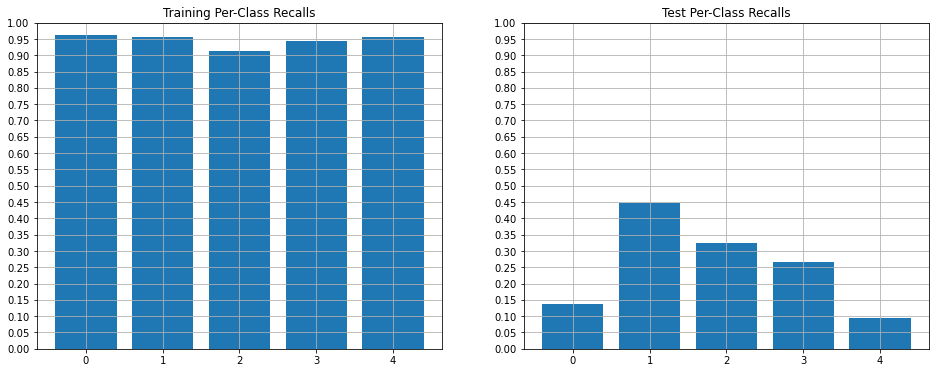

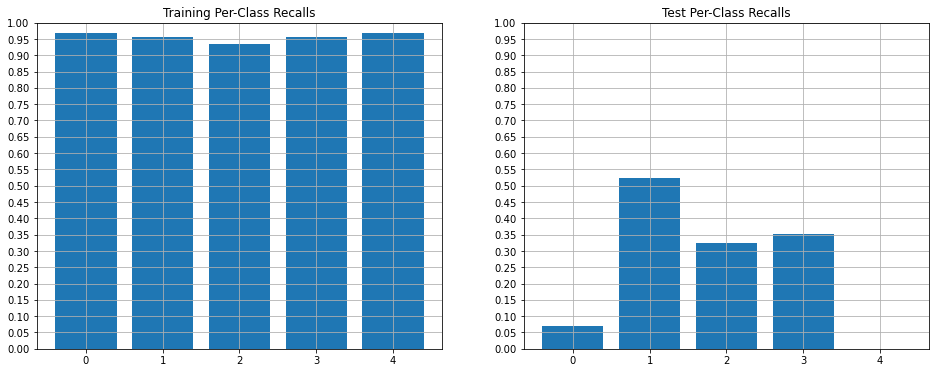

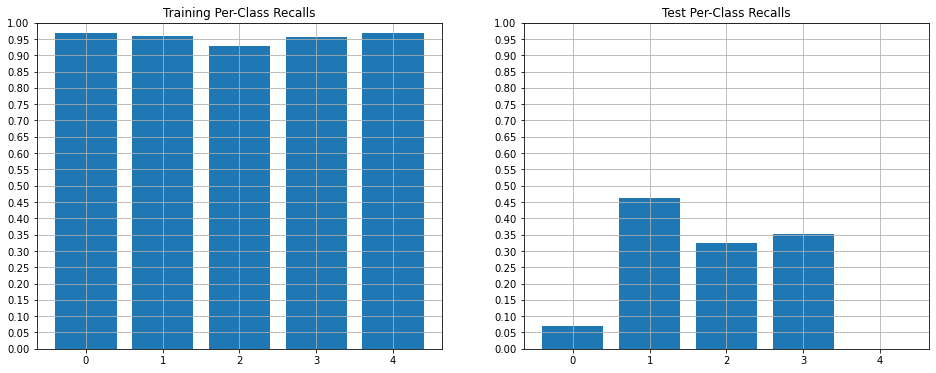

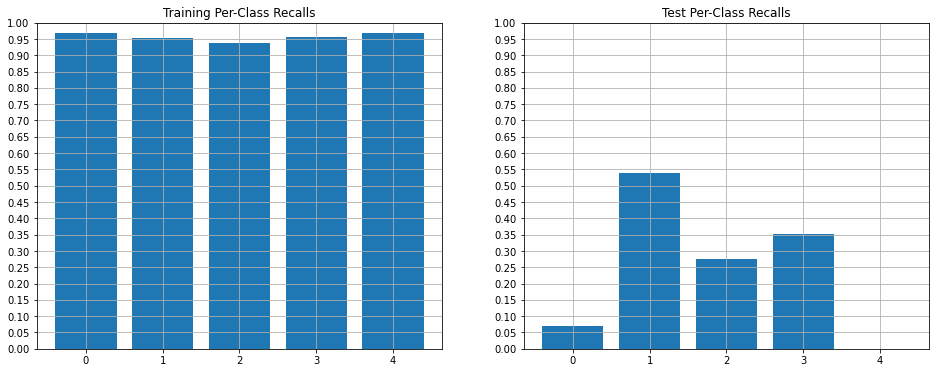

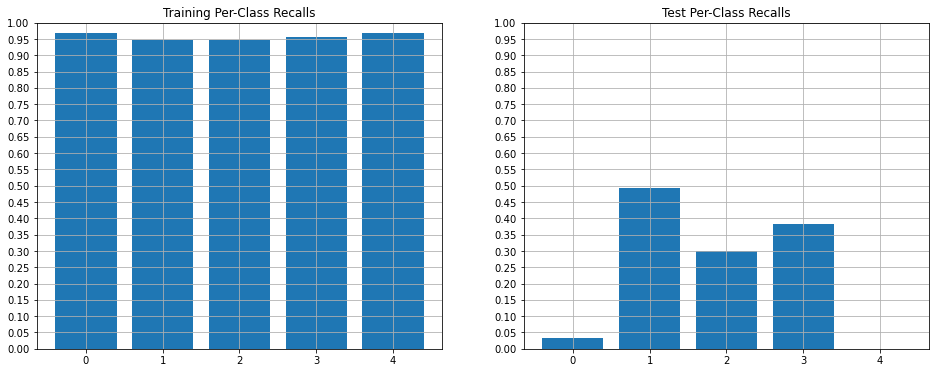

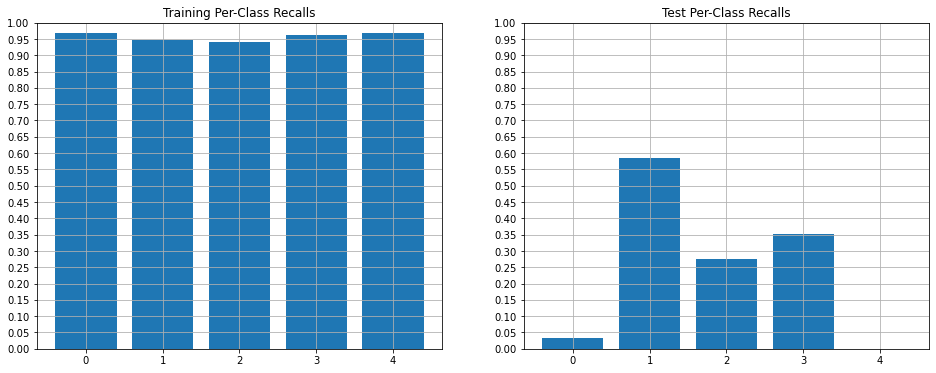

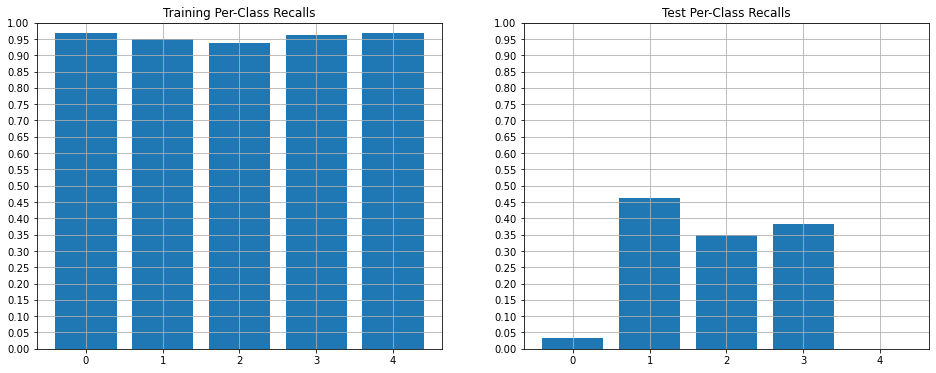

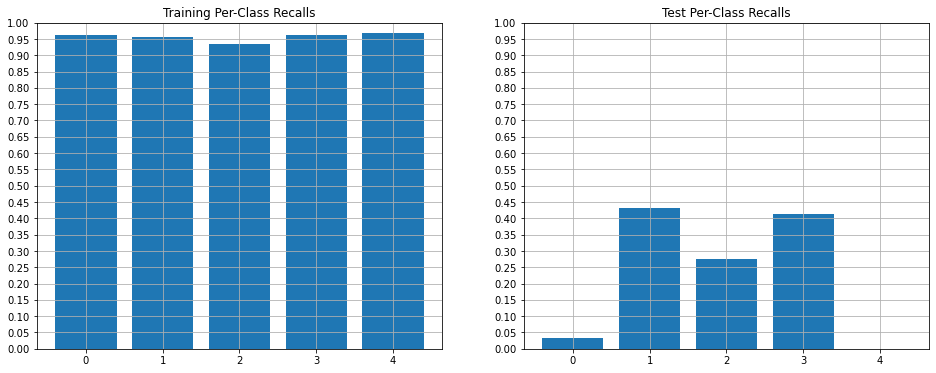

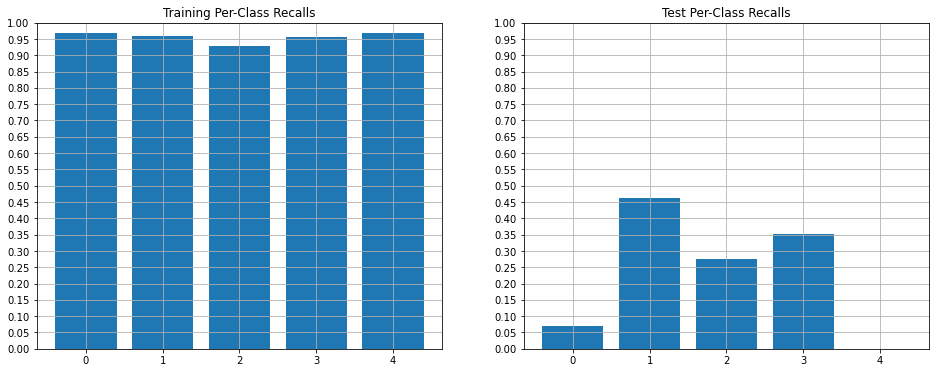

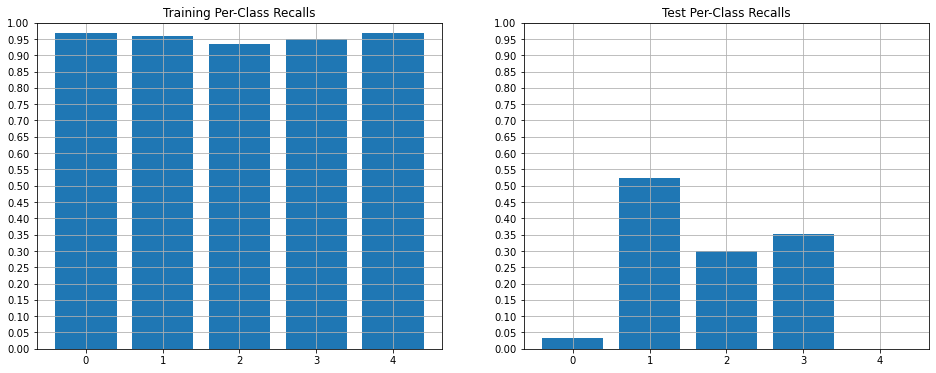

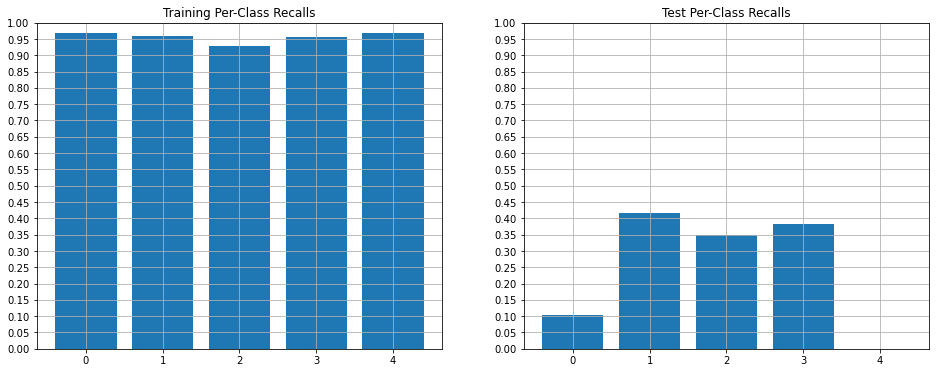

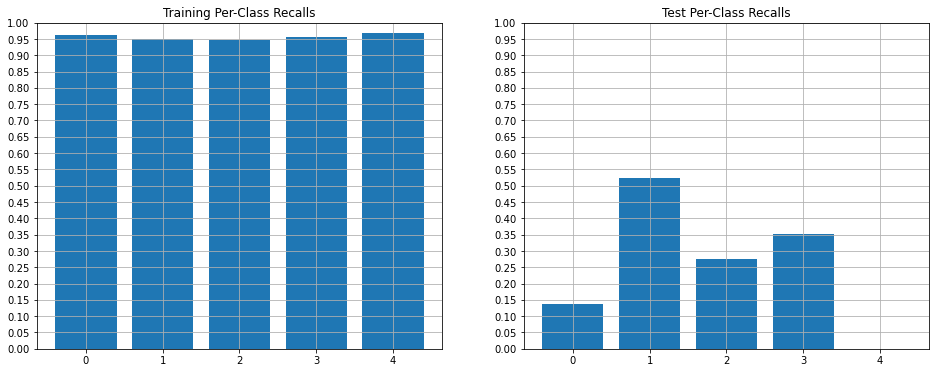

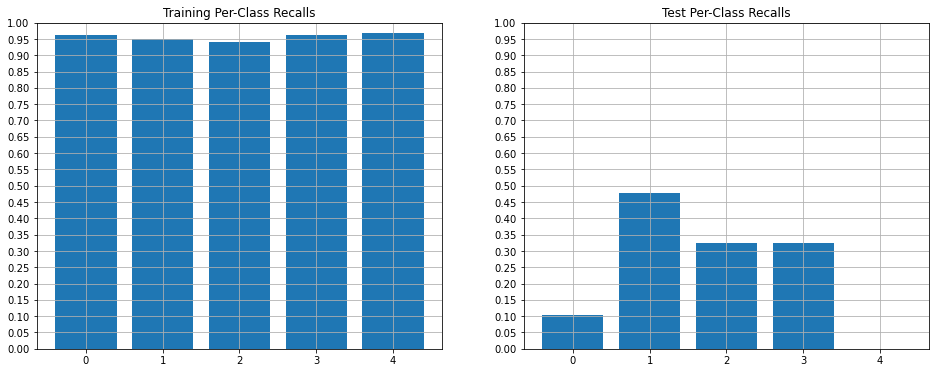

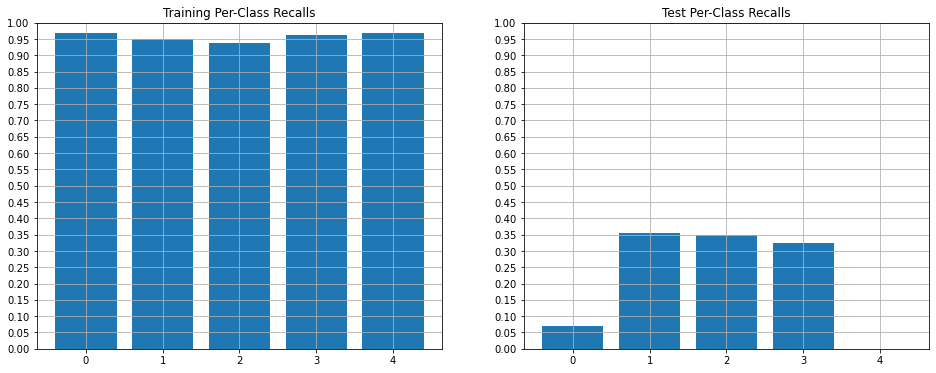

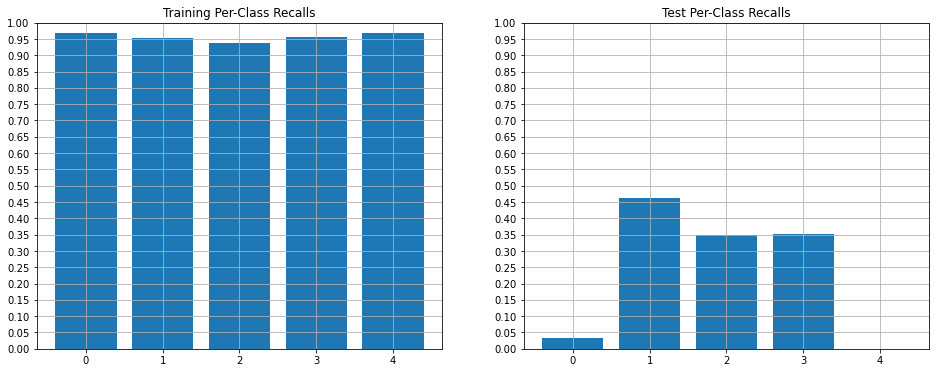

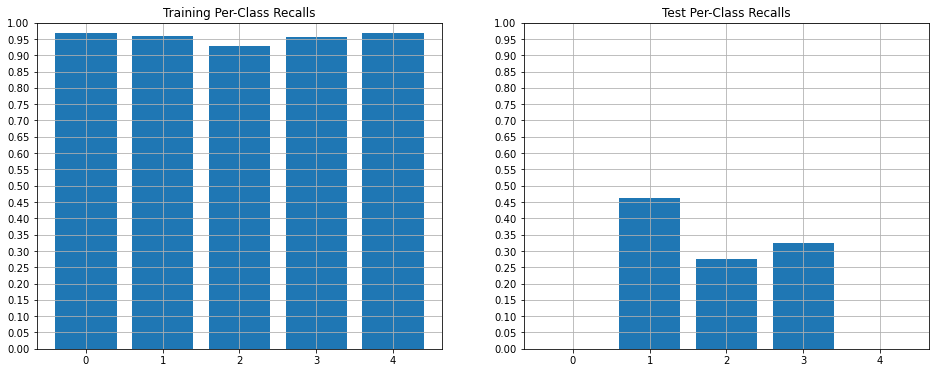

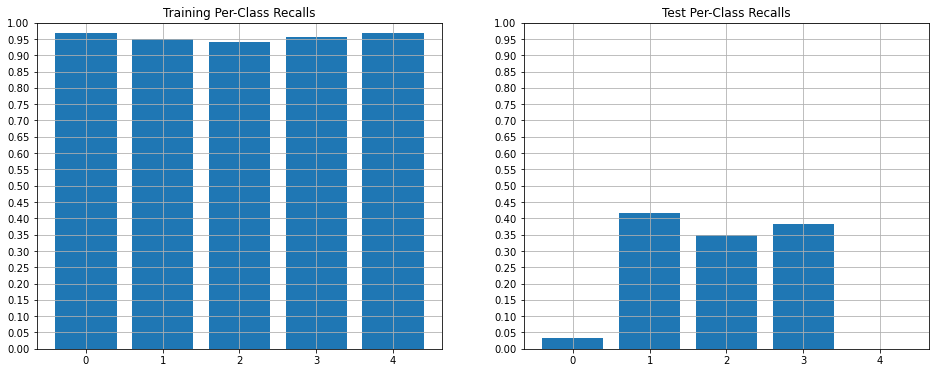

In [116]:
span_list = ['base', 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30]
train_results = []
test_results = []

base_train_bal, base_test_bal = train(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=0, WEIGHTED=False, PREVIOUS_NUM=0)
train_results.append(base_train_bal)
test_results.append(base_test_bal)

for span in span_list[1:]:
    print(f"span length is: {span}")
    train_bal, test_bal = train(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=0, WEIGHTED=True, WEIGHTED_DAYS = False, EWM_SPAN=span)
    train_results.append(train_bal)
    test_results.append(test_bal)


Text(0.5, 1.0, 'span length - split by participant - ewm weighted by span length - mean')

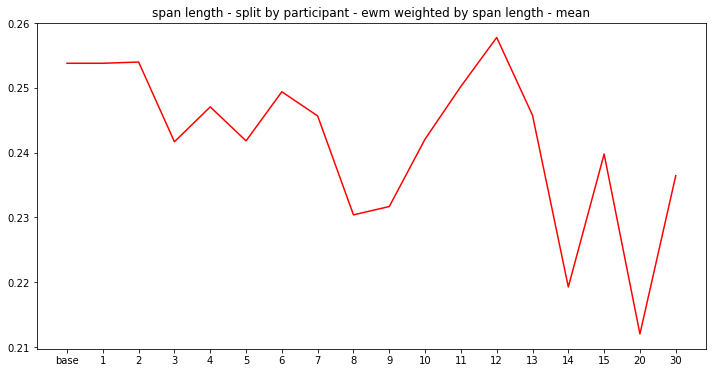

In [117]:
# plt.plot(span_list, train_results, 'b', label='Train')
plt.figure(figsize=(12, 6))
plt.plot(span_list, test_results, 'r', label='test')
plt.title('span length - split by participant - ewm weighted by span length - mean') #not split by participant, do not take any previous role

Train set shape: (963, 56)
Test set shape: (189, 56)
Ratio: 83.59%/16.41%

Random full accuracy: 21.44%
Train set:
Mean accuracy: 99.896%
Balanced accuracy: 99.870%
Test set:
Mean accuracy: 24.868%
Balanced accuracy: 19.282%
aggregate all previous data - mean


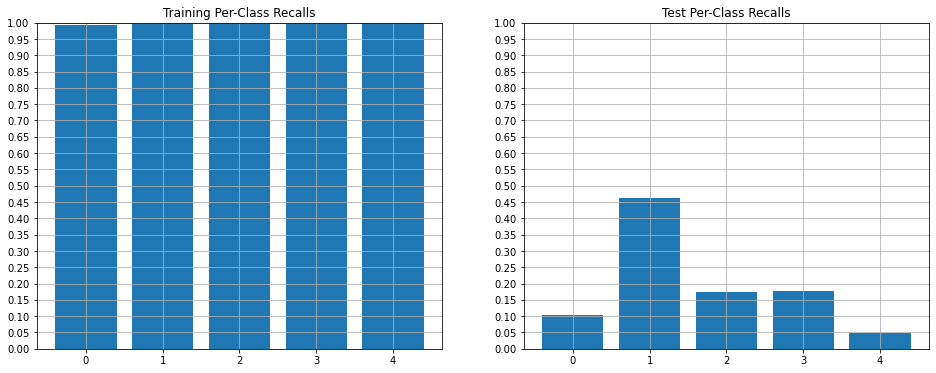

In [ ]:
train_bal, test_bal = train(ALL_PREVIOUS_DATA = True, SPLIT_BY_PARTICIPANT=True)
print('aggregate all previous data - mean')

In [ ]:
previous_num_list =np.arange(0,11,1)
train_results = []
test_results = []

for num in previous_num_list:
    print('previous_num:',num)
    train_bal, test_bal = train(PREVIOUS_NUM = num, ALL_PREVIOUS_DATA = False, TYPE='classification', SPLIT_BY_PARTICIPANT=True)
    train_results.append(train_bal)
    test_results.append(test_bal)
    

In [ ]:
plt.plot(previous_num_list, train_results, 'b', label='Train')
plt.plot(previous_num_list, test_results, 'r', label='test')
plt.title('classification') #not split by participant, do not take any previous role

In [ ]:
plt.plot(previous_num_list, train_results, 'b', label='Train')
plt.plot(previous_num_list, test_results, 'r', label='test')
plt.title('regression') #not split by participant, do not take any previous role

In [8]:


phq9 = dp.load_phq9_targets(DATADIR / "df_phq9.csv", type='classification', target='value')
locations = load_locations(DATADIR / "df_location_ratio.csv")
demographics = load_demographics(DATADIR / "df_demographics.csv")
mobility = load_passive_mobility(DATADIR / "df_passive_mobility_features.csv")
phone = load_passive_phone(
    DATADIR / "df_passive_phone_communication_features_brighten_v2.csv"
)
dailies=[
            ("locations", locations),
            ('mobility', mobility),
        #     # ('phone', phone)
        ]
constants=[demographics]
prev_phq9=False
all_previous_data=False
previous_num=1
weighted=True
weighted_days=True
ewm_halflife="7 days"
ewm_span=5 # Specify decay in terms of span
daily_reduction=["mean"]

"""
dailies: (name, csv) sequence, csv's are expected to have participant_id and date
constants: (name, csv) sequence too, csv's are expected to have participant_id only
weighted: weight the previous value inverse to the time length from last time point to current phq9 point
previous_num: combine daily data from previous phq9 test. (1: last test, 2: last 2 tests)
"""

# How does this work?
# Basically, "combine" daily data phq9 points from the start
# example:
# phq9  daily0  daily1
# 3.00  718     333
# 5.00  NaN     NaN
# NaN   333     444
# NaN   NaN     NaN
# NaN   444     555
# 4.00  NaN     NaN
# becomes (with mean reduction):
# phq9  daily0  daily1
# 3.00  718     333
# 5.00  718     333
# 4.00  498     444
#

if dailies is None:
    dailies = []

if constants is None:
    constants = []

# Remember that PHQ9 is also daily.
# Dailies should be (name, csv) pairs.

# Also, let's add an extra column has_* to check for daily attributes later
has_keys = ["has_phq9"]
phq9["has_phq9"] = True

for name, csv in dailies:
    k = f"has_{name}"
    csv[k] = True
    has_keys.append(k)

# Now, merge everything. Use an 'outer' merge so that all entries are included,
# and those who don't exist for that date get NaNs
daily_merged = phq9
for name, csv in dailies:
    daily_merged = daily_merged.merge(
        csv, on=["participant_id", "date"], how="outer"
    )
daily_merged.sort_values(by=["participant_id", "date"], inplace=True)

# To make things look a bit cleaner, replace NaN with False for has_* columns
# for has_key in has_keys:
#     daily_merged[has_key].fillna(False, inplace=True)

# if prev_phq9:  # previous phq9 test result
#     shifted_target = phq9.groupby("participant_id").apply(
#         lambda x: x["target"].shift(1)
#     )
#     shifted_target.fillna(0, inplace=True)
#     daily_merged["prev_target"] = shifted_target.reset_index(drop=True)

# def has_filt(col):
#     return col.startswith("has_")

# def last_filt(col):
#     return col in ("target", "date", "prev_target")

# def feature_filt(col):
#     return col != "participant_id" and not (has_filt(col) or last_filt(col))

# cols = daily_merged.columns
# aggdict = {
#     **{c: "last" for c in cols if last_filt(c)},
#     **{c: "max" for c in cols if has_filt(c)},
#     **{c: daily_reduction for c in cols if feature_filt(c)},
# }

# # COLUMNS_INDEX = ['participant_id', 'date', 'target', 'prev_target', 'has_phq9']
# COLUMNS_INDEX = [c for c in cols if last_filt(c)]
# COLUMNS_INDEX.append("has_phq9")
# COLUMNS_INDEX.insert(0, "participant_id")
# COLUMNS_HAS = [c for c in cols if has_filt(c)]
# COLUMNS_HAS.pop(0)
# COUNT_COLUMNS = [c for c in cols if feature_filt(c)]

# rename_dict = {}
# for c in cols:
#     if last_filt(c):
#         rename_dict[c, "last"] = c
#     elif has_filt(c):
#         rename_dict[c, "max"] = c
#     else:
#         for reduct in daily_reduction:
#             rename_dict[c, reduct] = c + "_" + reduct

# # finally, the grouping closure
# def _group_and_reduce_phq9(df):
#     inds = _group_by_phq9(df)
#     aggframe = df.groupby(inds).agg(aggdict)
#     aggframe.columns = [rename_dict[c] for c in aggframe.columns.to_flat_index()]
#     return aggframe

# def _group_by_phq9(df):
#     # Assign a different group number to each consecutive phq9 'block'
#     c = 0
#     groups = []
#     # Probably can derive this from some kind of cumsum, but brain is offline atm
#     for k in df.has_phq9:
#         groups.append(c)
#         if k:
#             c += 1
#     return groups

# def _reduce_phq9_cumulative(daily_merged, daily_reduction):
#     # cumulative reduction from the start
#     # TODO add more reduction methods, combine them within a dataframe
#     df = daily_merged[COLUMNS_INDEX]
#     for reduct in daily_reduction:
#         match reduct:
#             case "mean":
#                 df_cummean = (
#                     daily_merged.groupby(["participant_id"])[COUNT_COLUMNS]
#                     .expanding()
#                     .mean()
#                     .add_suffix("_mean")
#                     .reset_index()
#                     .fillna(0)
#                     .drop(columns=["level_1", "participant_id"])
#                 )
#                 df_cummax = (
#                     daily_merged.set_index(COLUMNS_INDEX)
#                     .groupby(level=0)
#                     .cummax()
#                     .reset_index()[COLUMNS_HAS]
#                 )
#                 df_cum = pd.concat(
#                     [daily_merged[COLUMNS_INDEX], df_cummax, df_cummean], axis=1
#                 )
#                 df = df.merge(
#                     df_cum,
#                     left_on=COLUMNS_INDEX,
#                     right_on=COLUMNS_INDEX,
#                     how="left",
#                 )

#             case "std":
#                 pass

#             case "max":
#                 df_cumcal = (
#                     daily_merged.set_index(COLUMNS_INDEX)
#                     .groupby(level=0)
#                     .cummax()
#                     .reset_index()[COUNT_COLUMNS]
#                     .add_suffix("_max")
#                 )
#                 df_cummax = (
#                     daily_merged.set_index(COLUMNS_INDEX)
#                     .groupby(level=0)
#                     .cummax()
#                     .reset_index()[COLUMNS_HAS]
#                 )
#                 df_cum = pd.concat(
#                     [daily_merged[COLUMNS_INDEX], df_cummax, df_cumcal], axis=1
#                 )
#                 df = df.merge(
#                     df_cum,
#                     left_on=COLUMNS_INDEX,
#                     right_on=COLUMNS_INDEX,
#                     how="left",
#                 )

#             case "min":
#                 df_cumcal = (
#                     daily_merged.set_index(COLUMNS_INDEX)
#                     .groupby(level=0)
#                     .cummin()
#                     .reset_index()[COUNT_COLUMNS]
#                     .add_suffix("_min")
#                 )
#                 df_cummax = (
#                     daily_merged.set_index(COLUMNS_INDEX)
#                     .groupby(level=0)
#                     .cummax()
#                     .reset_index()[COLUMNS_HAS]
#                 )
#                 df_cum = pd.concat(
#                     [daily_merged[COLUMNS_INDEX], df_cummax, df_cumcal], axis=1
#                 )
#                 df = df.merge(
#                     df_cum,
#                     left_on=COLUMNS_INDEX,
#                     right_on=COLUMNS_INDEX,
#                     how="left",
#                 )
#             case _:
#                 KeyError("reduction method not found")
#     return df

# # 1. daily_rows has all the aggregated data we want, and each rows should have
# # a phq9 score. However, there is a possible issue: trailing location data
# # with no final phq9, which would lead to an empty group. We can remove such rows
# # easily by checking has_phq9, which should be 0 since no phq9 was aggregated.
# if all_previous_data:
#     daily_rows = _reduce_phq9_cumulative(daily_merged, daily_reduction)
#     daily_rows.fillna(0.0, inplace=True)
#     daily_rows = daily_rows[daily_rows.has_phq9 > 0.0]

# else:
#     pgrp = daily_merged.groupby("participant_id")
#     daily_rows = pgrp.apply(_group_and_reduce_phq9)
#     daily_rows.fillna(0.0, inplace=True)
#     daily_rows = daily_rows[daily_rows.has_phq9 > 0.0]
#     daily_rows = daily_rows.reset_index()
#     daily_rows.drop(columns=["level_1"], inplace=True)

#     columns_cal = []
#     for col in daily_rows.columns:
#         if col not in COLUMNS_INDEX and col not in COLUMNS_HAS:
#             columns_cal.append(col)

#     if weighted:
#         if weighted_days:
#             columns_index = COLUMNS_INDEX[1:]
#             daily_rows = (
#                 daily_rows.set_index(columns_index + COLUMNS_HAS)
#                 .groupby(["participant_id"])[columns_cal]
#                 .ewm(halflife=ewm_halflife, times=daily_rows["date"])
#                 .mean()
#                 .reset_index()
#             )
#         else:
#             daily_rows = (
#                 daily_rows.set_index(COLUMNS_INDEX + COLUMNS_HAS)
#                 .groupby(level=0)
#                 .transform(lambda s: s.ewm(span=ewm_span).mean())
#                 .reset_index()
#             )

#     else:  # cumulative previous_num test data without weighting
#         if previous_num == 0:
#             pass
#         else:
#             daily_rows = (
#                 daily_rows.set_index(COLUMNS_INDEX + COLUMNS_HAS)
#                 .groupby(["participant_id"])[columns_cal]
#                 .transform(lambda s: s.rolling(previous_num, min_periods=1).mean())
#                 .reset_index()
#             )

# # Now, append the constants to each row
# for const in constants:
#     daily_rows = daily_rows.merge(const, on="participant_id")


In [9]:
daily_merged

,participant_id,date,target,has_phq9,automotive,consumer_goods,dining_out,education,entertainment,finance,...,hours_accounted_for,hours_active,hours_high_speed_transportation,hours_of_sleep,hours_powered_vehicle,hours_stationary,hours_stationary_nhw,hours_walking,location_variance,has_mobility
0,BLUE-00048,2014-08-08,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BLUE-00050,2014-08-23,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BLUE-00050,2014-08-30,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BLUE-00050,2014-09-08,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BLUE-00050,2014-09-22,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3622,YELLOW-00262,2014-12-31,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3623,YELLOW-00263,2014-12-17,2.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3624,YELLOW-00263,2014-12-24,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3625,YELLOW-00263,2014-12-31,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
daily_merged.has_phq9.value_counts()

True    4782
Name: has_phq9, dtype: int64

In [13]:
combined, merged = dp.combine(
        phq9,
        dailies=[
            ("locations", locations),
            ('mobility', mobility),
        #     # ('phone', phone)
        ],
        constants=[demographics],
    )

In [14]:
combined

,participant_id,date,target,has_phq9,has_locations,has_mobility,automotive_mean,automotive_std,consumer_goods_mean,consumer_goods_std,...,edu_None,edu_University,race_African-American/Black,race_American Indian/Alaskan Native,race_Asian,race_Hispanic/Latino,race_More than one,race_Native Hawaiian/other Pacific Islander,race_Non-Hispanic White,race_Other
0,EN00035,2016-08-21,0.0,True,False,False,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
1,EN00035,2016-08-29,0.0,True,False,False,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
2,EN00035,2016-09-04,0.0,True,False,False,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
3,EN00035,2016-09-11,0.0,True,False,False,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
4,EN00039,2016-08-29,3.0,True,False,False,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,ES05073,2017-02-05,2.0,True,True,True,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1148,ES05073,2017-02-19,2.0,True,True,True,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1149,ES05073,2017-02-26,0.0,True,True,True,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1150,ES05073,2017-03-12,4.0,True,True,True,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
